In [41]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
#from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, classification_report

import datetime
import time
import warnings
warnings.filterwarnings('ignore')

# to display the total number columns present in the dataset
pd.set_option('display.max_columns', None)

In [42]:
def reduce_mem_usage(props):
    start_mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in props.columns:
        if props[col].dtype != object:  # Exclude strings
            
            # Print current column type
            print("******************************")
            print("Column: ",col)
            print("dtype before: ",props[col].dtype)
            
            # make variables for Int, max and min
            IsInt = False
            mx = props[col].max()
            mn = props[col].min()
            
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(props[col]).all(): 
                NAlist.append(col)
                props[col].fillna(mn-1,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = props[col].fillna(0).astype(np.int64)
            result = (props[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True

            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        props[col] = props[col].astype(np.uint8)
                    elif mx < 65535:
                        props[col] = props[col].astype(np.uint16)
                    elif mx < 4294967295:
                        props[col] = props[col].astype(np.uint32)
                    else:
                        props[col] = props[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        props[col] = props[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        props[col] = props[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        props[col] = props[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        props[col] = props[col].astype(np.int64)    
            
            # Make float datatypes 32 bit
            else:
                props[col] = props[col].astype(np.float32)
            
            # Print new column type
            print("dtype after: ",props[col].dtype)
            print("******************************")
    
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return props, NAlist

In [43]:
df=pd.read_csv('Telco-Customer-Churn.csv')
df.shape

(7043, 21)

In [44]:
# replace empty strings with nan
df = df.replace(r'^\s*$', np.nan, regex=True)

In [45]:
# percentage of missing values
df.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [46]:
# drop 11 rows have nans in 
df=df.dropna(axis=0)
df.shape

(7032, 21)

In [47]:
df, NAlist = reduce_mem_usage(df)
print("_________________")
print("")
print("Warning: the following columns have missing values filled with 'df['column_name'].min() -1': ")
print("_________________")
print("")
print(NAlist)

Memory usage of properties dataframe is : 1.1802978515625  MB
******************************
Column:  SeniorCitizen
dtype before:  int64
dtype after:  uint8
******************************
******************************
Column:  tenure
dtype before:  int64
dtype after:  uint8
******************************
******************************
Column:  MonthlyCharges
dtype before:  float64
dtype after:  float32
******************************
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  1.0595855712890625  MB
This is  89.77272727272727 % of the initial size
_________________

_________________

[]


In [48]:
df.groupby(['Churn']).size().reset_index(name='counts')

,Churn,counts
0,No,5163
1,Yes,1869


In [49]:
# Check distribution of fraud and non-fraud transactions - data is imbalanced
df['Churn'].value_counts() / df.shape[0]

No     0.734215
Yes    0.265785
Name: Churn, dtype: float64

In [50]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.850000,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.950001,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.849998,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.299999,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.699997,151.65,Yes


In [51]:
df.TotalCharges = df.TotalCharges.astype(float)

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7032 non-null object
gender              7032 non-null object
SeniorCitizen       7032 non-null uint8
Partner             7032 non-null object
Dependents          7032 non-null object
tenure              7032 non-null uint8
PhoneService        7032 non-null object
MultipleLines       7032 non-null object
InternetService     7032 non-null object
OnlineSecurity      7032 non-null object
OnlineBackup        7032 non-null object
DeviceProtection    7032 non-null object
TechSupport         7032 non-null object
StreamingTV         7032 non-null object
StreamingMovies     7032 non-null object
Contract            7032 non-null object
PaperlessBilling    7032 non-null object
PaymentMethod       7032 non-null object
MonthlyCharges      7032 non-null float32
TotalCharges        7032 non-null float64
Churn               7032 non-null object
dtypes: float32(1), float64(1), 

In [53]:
# drop columns with all nans
df=df.dropna(axis=1, how='all')

In [54]:
# drop rows with all nans
df=df.dropna(axis=0)

In [55]:
df.shape

(7032, 21)

In [56]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.162400,32.421786,64.798347,2283.300441
std,0.368844,24.545260,30.085947,2266.771362
min,0.000000,1.000000,18.250000,18.800000
25%,0.000000,9.000000,35.587499,401.450000
50%,0.000000,29.000000,70.349998,1397.475000
75%,0.000000,55.000000,89.862499,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


In [57]:
# how many labels in each variable
for col in df.columns:
    print(col, ': ', len(df[col].unique()), ' labels')

customerID :  7032  labels
gender :  2  labels
SeniorCitizen :  2  labels
Partner :  2  labels
Dependents :  2  labels
tenure :  72  labels
PhoneService :  2  labels
MultipleLines :  3  labels
InternetService :  3  labels
OnlineSecurity :  3  labels
OnlineBackup :  3  labels
DeviceProtection :  3  labels
TechSupport :  3  labels
StreamingTV :  3  labels
StreamingMovies :  3  labels
Contract :  3  labels
PaperlessBilling :  2  labels
PaymentMethod :  4  labels
MonthlyCharges :  1584  labels
TotalCharges :  6530  labels
Churn :  2  labels


In [58]:
#replace values in columns with binary features

binary_cols=['Partner','Dependents','PhoneService','PaperlessBilling','Churn']

for i in binary_cols:
    df[i]=df[i].replace({"Yes":1,"No":0})

#Encoding column 'gender'
df['gender']=df['gender'].replace({"Male":1,"Female":0})


In [59]:
df.PaymentMethod.value_counts(dropna=False)

Electronic check             2365
Mailed check                 1604
Bank transfer (automatic)    1542
Credit card (automatic)      1521
Name: PaymentMethod, dtype: int64

In [60]:
df.MultipleLines.value_counts(dropna=False)

No                  3385
Yes                 2967
No phone service     680
Name: MultipleLines, dtype: int64

In [61]:
df.InternetService.value_counts(dropna=False)

Fiber optic    3096
DSL            2416
No             1520
Name: InternetService, dtype: int64

In [62]:
df.TotalCharges.value_counts(dropna=False)

20.20      11
19.75       9
19.65       8
20.05       8
19.90       8
           ..
1066.15     1
249.95      1
8333.95     1
7171.70     1
1024.00     1
Name: TotalCharges, Length: 6530, dtype: int64

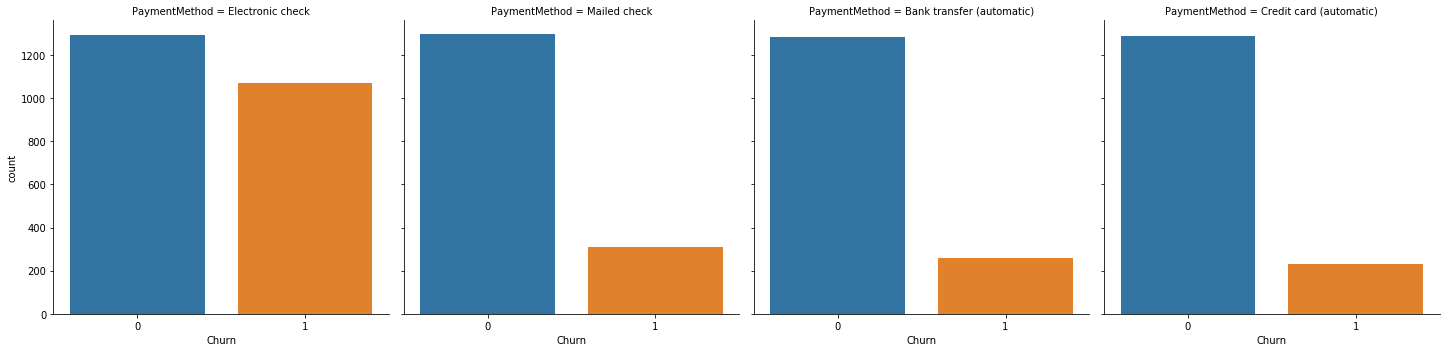

In [63]:
sns.catplot(x='Churn', col='PaymentMethod', kind='count', data=df)

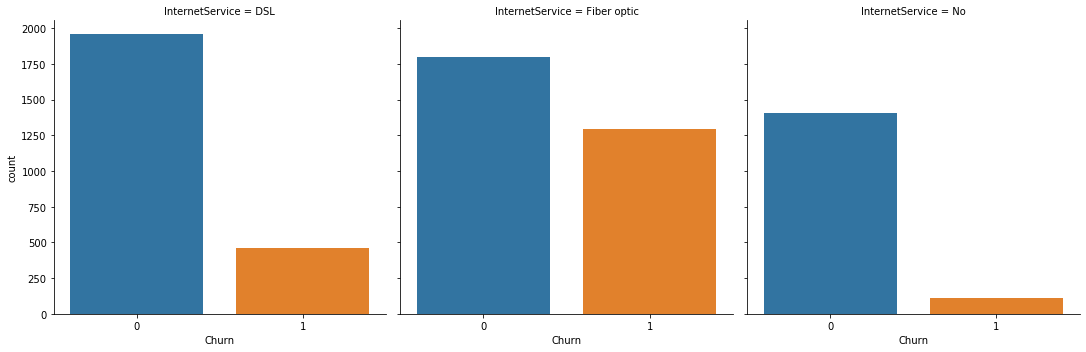

In [64]:
sns.catplot(x='Churn', col='InternetService', kind='count', data=df)

In [65]:
df.groupby(['Churn','InternetService'])['InternetService'].count().unstack(fill_value=0).stack()

Churn  InternetService
0      DSL                1957
       Fiber optic        1799
       No                 1407
1      DSL                 459
       Fiber optic        1297
       No                  113
dtype: int64

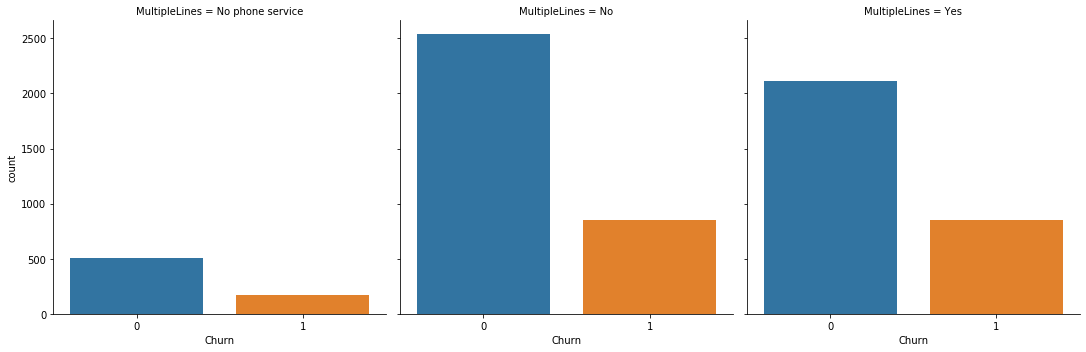

In [66]:
sns.catplot(x='Churn', col='MultipleLines', kind='count', data=df)

In [67]:
def get_type_lists(data_frame=df, rejects=['customerID']):
    """Creates lists of numeric and categorical variables.    
    :param frame: The frame from which to determine types.
    :param rejects: Variable names not to be included in returned lists.
    :return: Tuple of lists for numeric and categorical variables in the frame.
    """
    nums, cats = [], []

    for col in data_frame.columns:
        if col not in rejects:
            type=data_frame[col].dtype
            if type in ('uint8','int64','int32','float32','float64') :
                nums.append(col)
            elif str(type) in ('object')  :
                cats.append(col)
                
    print('Numeric =', nums)                
    print()
    print('Categorical =', cats)
    
    return nums, cats

In [68]:
original_nums, cats = get_type_lists()

Numeric = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'Churn']

Categorical = ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']


In [69]:
# Encoding categorical data
df = pd.get_dummies(df,columns=cats, drop_first=True) #, dummy_na=True)
df.shape

(7032, 32)

In [70]:
df.shape

(7032, 32)

Text(0.5, 0, 'Monthly Charges')

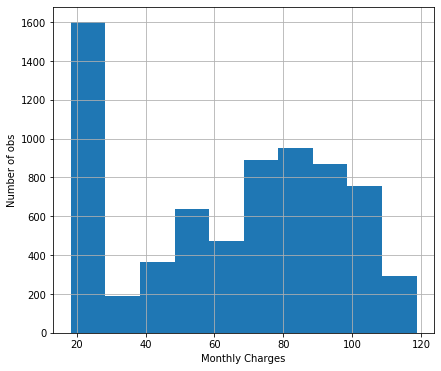

In [71]:
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
fig = df.MonthlyCharges.hist(bins=10)
fig.set_ylabel('Number of obs')
fig.set_xlabel('Monthly Charges')

In [72]:
# find and remove correlated features to reduce the feature space
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

corr_features = correlation(df, 0.75)
print('correlated features: ', len(set(corr_features)) )

correlated features:  10


In [73]:
corr_features

{'DeviceProtection_No internet service',
 'InternetService_Fiber optic',
 'InternetService_No',
 'MultipleLines_No phone service',
 'OnlineBackup_No internet service',
 'OnlineSecurity_No internet service',
 'StreamingMovies_No internet service',
 'StreamingTV_No internet service',
 'TechSupport_No internet service',
 'TotalCharges'}

In [74]:
# removed correlated  features
#df.drop(labels=corr_features, axis=1, inplace=True)

In [75]:
y = df.Churn
X = df.drop("Churn", axis=1)

In [76]:
# Split the 'features' and 'Churn' target data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X.drop(['customerID'], axis=1), y, 
                                                    test_size = 0.3, 
                                                    random_state = 0,
                                                    stratify=y,
                                                    shuffle=True)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 4922 samples.
Testing set has 2110 samples.


In [77]:
X_train.shape, X_test.shape

((4922, 30), (2110, 30))

In [78]:
pos_count = y_train.sum()
neg_count = len(y_train) - pos_count
imbalance_ratio = neg_count / pos_count

In [79]:
from xgboost.sklearn import XGBClassifier

# Create the XGB classifier, xgb_model.
xgb_model = XGBClassifier(n_estimators=400, scale_pos_weight= imbalance_ratio, learning_rate= 0.01,
                          max_delta_step=1,eval_metric='AUC',
                          max_depth=8,subsample=0.8,nthread=4)

In [80]:
# Train and evaluate.
xgb_model.fit(X_train, y_train, eval_metric=['error'], eval_set=[((X_train, y_train)),(X_test, y_test)])

[0]	validation_0-error:0.217188	validation_1-error:0.267299
[1]	validation_0-error:0.202357	validation_1-error:0.245972
[2]	validation_0-error:0.199919	validation_1-error:0.247867
[3]	validation_0-error:0.196059	validation_1-error:0.247867
[4]	validation_0-error:0.192605	validation_1-error:0.24455
[5]	validation_0-error:0.191589	validation_1-error:0.244076
[6]	validation_0-error:0.193417	validation_1-error:0.238863
[7]	validation_0-error:0.190776	validation_1-error:0.240758
[8]	validation_0-error:0.189354	validation_1-error:0.235545
[9]	validation_0-error:0.188948	validation_1-error:0.236967
[10]	validation_0-error:0.187729	validation_1-error:0.240758
[11]	validation_0-error:0.187932	validation_1-error:0.236967
[12]	validation_0-error:0.186916	validation_1-error:0.239336
[13]	validation_0-error:0.187729	validation_1-error:0.239336
[14]	validation_0-error:0.186916	validation_1-error:0.240758
[15]	validation_0-error:0.187322	validation_1-error:0.238389
[16]	validation_0-error:0.187525	va

[135]	validation_0-error:0.176351	validation_1-error:0.240284
[136]	validation_0-error:0.176554	validation_1-error:0.240284
[137]	validation_0-error:0.175945	validation_1-error:0.239336
[138]	validation_0-error:0.176148	validation_1-error:0.240284
[139]	validation_0-error:0.176554	validation_1-error:0.23981
[140]	validation_0-error:0.176554	validation_1-error:0.239336
[141]	validation_0-error:0.175538	validation_1-error:0.239336
[142]	validation_0-error:0.175538	validation_1-error:0.238863
[143]	validation_0-error:0.175538	validation_1-error:0.239336
[144]	validation_0-error:0.175335	validation_1-error:0.239336
[145]	validation_0-error:0.175335	validation_1-error:0.239336
[146]	validation_0-error:0.175335	validation_1-error:0.23981
[147]	validation_0-error:0.174929	validation_1-error:0.240284
[148]	validation_0-error:0.175335	validation_1-error:0.23981
[149]	validation_0-error:0.174929	validation_1-error:0.23981
[150]	validation_0-error:0.174929	validation_1-error:0.23981
[151]	validat

[268]	validation_0-error:0.157863	validation_1-error:0.236967
[269]	validation_0-error:0.157659	validation_1-error:0.236493
[270]	validation_0-error:0.157659	validation_1-error:0.236493
[271]	validation_0-error:0.157456	validation_1-error:0.236493
[272]	validation_0-error:0.157863	validation_1-error:0.236493
[273]	validation_0-error:0.156847	validation_1-error:0.236493
[274]	validation_0-error:0.15705	validation_1-error:0.236967
[275]	validation_0-error:0.156644	validation_1-error:0.236493
[276]	validation_0-error:0.156034	validation_1-error:0.236967
[277]	validation_0-error:0.155425	validation_1-error:0.237441
[278]	validation_0-error:0.155628	validation_1-error:0.237441
[279]	validation_0-error:0.155628	validation_1-error:0.236967
[280]	validation_0-error:0.155628	validation_1-error:0.236967
[281]	validation_0-error:0.155425	validation_1-error:0.236493
[282]	validation_0-error:0.155221	validation_1-error:0.236493
[283]	validation_0-error:0.155221	validation_1-error:0.236967
[284]	val

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='AUC',
              gamma=0, learning_rate=0.01, max_delta_step=1, max_depth=8,
              min_child_weight=1, missing=None, n_estimators=400, n_jobs=1,
              nthread=4, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=2.7629969418960245,
              seed=None, silent=None, subsample=0.8, verbosity=1)

In [81]:
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore")

y_pred = xgb_model.predict(X_test)  #predicts
print('confusion matrix')
print(metrics.confusion_matrix(y_test, y_pred))
print('classification report')
print(metrics.classification_report(y_test, y_pred))
print("-----------------------------------------------------------------------------------------")
print("Accuracy is :")
print(metrics.accuracy_score(y_test, y_pred))
print('Area under the curve : %f' % (metrics.roc_auc_score(y_test, y_pred)))

confusion matrix
[[1210  339]
 [ 152  409]]
classification report
              precision    recall  f1-score   support

           0       0.89      0.78      0.83      1549
           1       0.55      0.73      0.62       561

    accuracy                           0.77      2110
   macro avg       0.72      0.76      0.73      2110
weighted avg       0.80      0.77      0.78      2110

-----------------------------------------------------------------------------------------
Accuracy is :
0.7672985781990521
Area under the curve : 0.755102


In [82]:
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore")

y_pred = xgb_model.predict(X_test)  #predicts
print('confusion matrix')
print(metrics.confusion_matrix(y_test, y_pred))
print('classification report')
print(metrics.classification_report(y_test, y_pred))
print("-----------------------------------------------------------------------------------------")
print("Accuracy is :")
print(metrics.accuracy_score(y_test, y_pred))
print('Area under the curve : %f' % (metrics.roc_auc_score(y_test, y_pred)))

confusion matrix
[[1210  339]
 [ 152  409]]
classification report
              precision    recall  f1-score   support

           0       0.89      0.78      0.83      1549
           1       0.55      0.73      0.62       561

    accuracy                           0.77      2110
   macro avg       0.72      0.76      0.73      2110
weighted avg       0.80      0.77      0.78      2110

-----------------------------------------------------------------------------------------
Accuracy is :
0.7672985781990521
Area under the curve : 0.755102


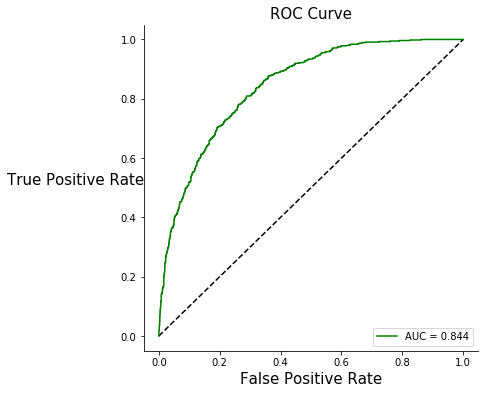

In [83]:
#from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve,auc
from seaborn import despine

logit_roc_auc = roc_auc_score(y_test, xgb_model.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, xgb_model.predict_proba(X_test)[:,1])

roc_auc = auc(fpr,tpr)

plt.figure(figsize=(6,6))


# Plotting our Baseline..
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr, tpr,'g',label='AUC = %0.3f'% roc_auc)
plt.legend(loc='lower right')
plt.title('ROC Curve',fontsize = 15)
plt.xlabel('False Positive Rate',fontsize = 15)
plt.ylabel('True Positive Rate',rotation=0,labelpad=45,fontsize = 15)
despine()


In [84]:
from catboost import CatBoostClassifier
catb_model = CatBoostClassifier(random_seed=42, od_type='Iter', 
                                iterations=200, depth=8, learning_rate=0.001,
                                od_wait=20, eval_metric='AUC')

In [85]:
# Train and evaluate.
catb_model.fit(X_train, y_train, eval_set=[((X_train, y_train)),(X_test, y_test)])

0:	test: 0.8297329	test1: 0.8221991	best: 0.8221991 (0)	total: 63.7ms	remaining: 12.7s
1:	test: 0.8405470	test1: 0.8322804	best: 0.8322804 (1)	total: 71.2ms	remaining: 7.05s
2:	test: 0.8429975	test1: 0.8331043	best: 0.8331043 (2)	total: 78.2ms	remaining: 5.13s
3:	test: 0.8471621	test1: 0.8386165	best: 0.8386165 (3)	total: 84.9ms	remaining: 4.16s
4:	test: 0.8472592	test1: 0.8396924	best: 0.8396924 (4)	total: 90.5ms	remaining: 3.53s
5:	test: 0.8480682	test1: 0.8417023	best: 0.8417023 (5)	total: 96.5ms	remaining: 3.12s
6:	test: 0.8490273	test1: 0.8426545	best: 0.8426545 (6)	total: 103ms	remaining: 2.83s
7:	test: 0.8477359	test1: 0.8423007	best: 0.8426545 (6)	total: 106ms	remaining: 2.54s
8:	test: 0.8469029	test1: 0.8414422	best: 0.8426545 (6)	total: 111ms	remaining: 2.36s
9:	test: 0.8465864	test1: 0.8406361	best: 0.8426545 (6)	total: 117ms	remaining: 2.22s
10:	test: 0.8474787	test1: 0.8412299	best: 0.8426545 (6)	total: 122ms	remaining: 2.09s
11:	test: 0.8481198	test1: 0.8424485	best: 0.84

In [86]:
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore")

y_pred = catb_model.predict(X_test)  #predicts
print('confusion matrix')
print(metrics.confusion_matrix(y_test, y_pred))
print('classification report')
print(metrics.classification_report(y_test, y_pred))
print("-----------------------------------------------------------------------------------------")
print("Accuracy is :")
print(metrics.accuracy_score(y_test, y_pred))
print('Area under the curve : %f' % (metrics.roc_auc_score(y_test, y_pred)))

confusion matrix
[[1430  119]
 [ 301  260]]
classification report
              precision    recall  f1-score   support

           0       0.83      0.92      0.87      1549
           1       0.69      0.46      0.55       561

    accuracy                           0.80      2110
   macro avg       0.76      0.69      0.71      2110
weighted avg       0.79      0.80      0.79      2110

-----------------------------------------------------------------------------------------
Accuracy is :
0.8009478672985783
Area under the curve : 0.693317


In [87]:
# List the default parameters.
print(catb_model.get_params())

{'iterations': 200, 'learning_rate': 0.001, 'depth': 8, 'od_wait': 20, 'od_type': 'Iter', 'random_seed': 42, 'eval_metric': 'AUC'}


In [88]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_test, y_pred)
cm

array([[1430,  119],
       [ 301,  260]])

In [89]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_test, y_pred)
cm

array([[1430,  119],
       [ 301,  260]])